In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as  xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")



In [2]:
#read file
df = pd.read_csv("total_frequency_bydate.csv")
#set data as index
df = df.set_index("date")
#convert date to date type
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,Frequency
date,
2016-01-01,561
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345


<function matplotlib.pyplot.show(close=None, block=None)>

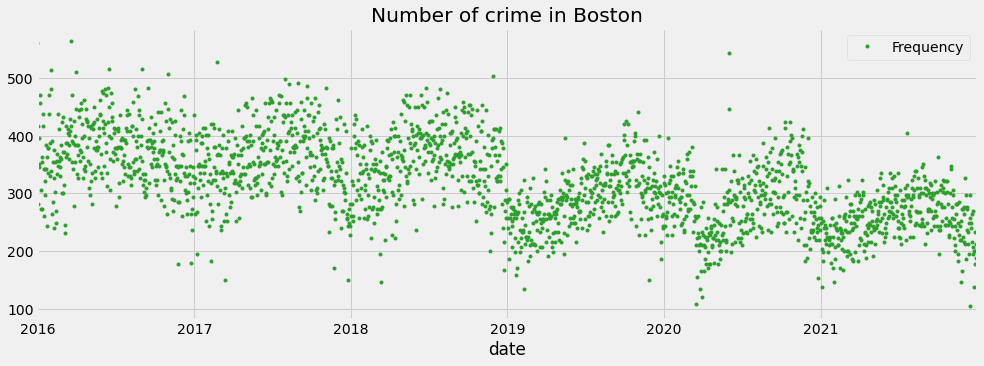

In [4]:
#visualize the data
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[2],
        title="Number of crime in Boston")
plt.show

<AxesSubplot:ylabel='Frequency'>

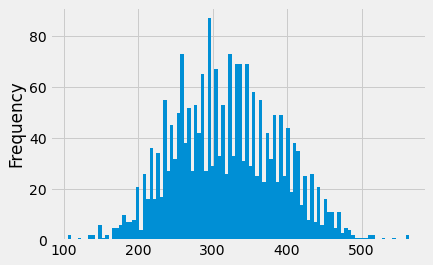

In [5]:
#outlier analysis and removal
#histogram
df['Frequency'].plot(kind="hist",bins=100)

<AxesSubplot:xlabel='date'>

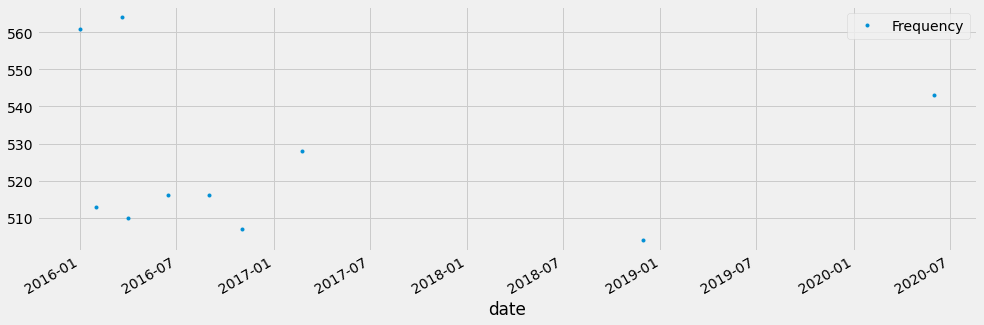

In [6]:
df.query('Frequency >500').plot(figsize=(15,5),style=".")

<AxesSubplot:xlabel='date'>

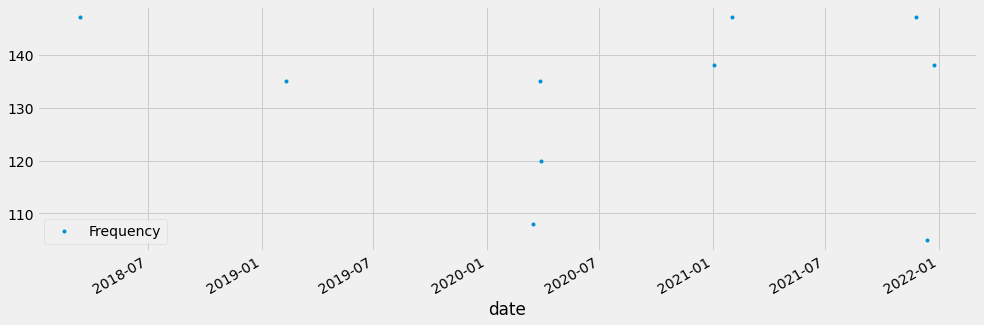

In [7]:
df.query('Frequency < 150').plot(figsize=(15,5),style=".")

In [8]:
#remove outlier
df = df.query('Frequency > 150' and 'Frequency < 500')

df

,Frequency
date,
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345
2016-01-06,396
...,...
2021-12-27,234
2021-12-28,213
2021-12-29,201


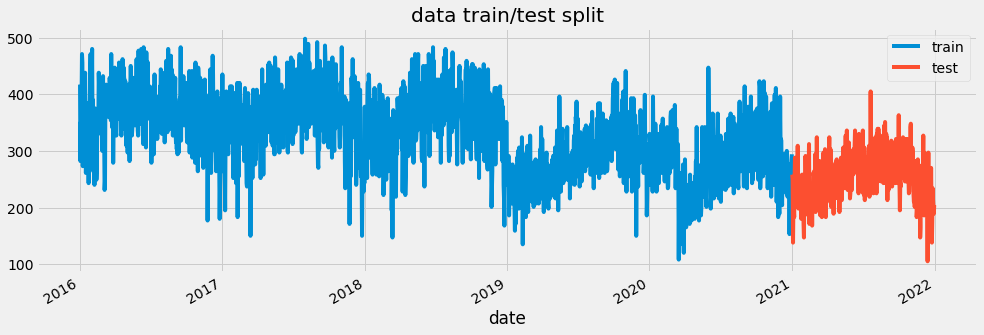

In [9]:
#train test split
train = df.loc[df.index<'01-01-2021']
test = df.loc[df.index>='01-01-2021']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="train",title='data train/test split')
test.plot(ax=ax,label='test')
ax.legend(['train','test'])
plt.show()

In [10]:
#time series cross validation
from sklearn.model_selection import TimeSeriesSplit


In [43]:
#360 days 
tss = TimeSeriesSplit(n_splits=5,test_size=360,gap=30)
df = df.sort_index()

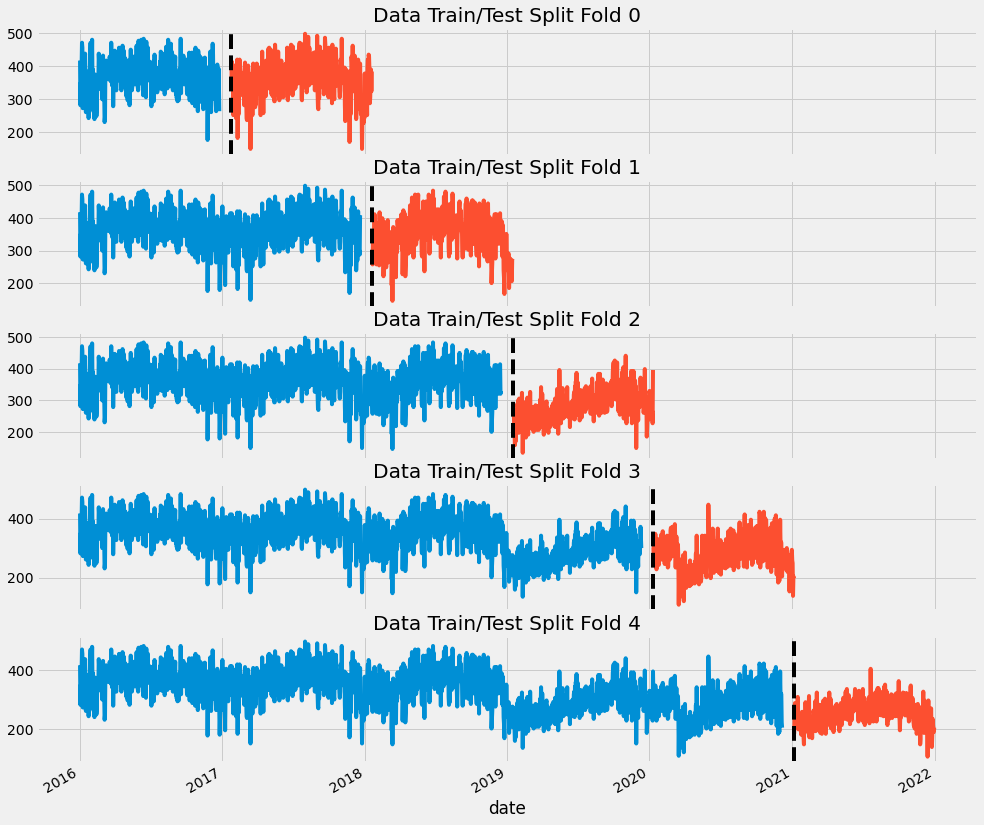

In [44]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Frequency'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Frequency'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [13]:
#forecasting
#feature creation
def create_feature(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    return df 
df = create_feature(df)



In [14]:
#lag features
target_map = df['Frequency'].to_dict()

In [15]:
def add_lags(df):
    target_map = df['Frequency'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df

In [16]:
df = add_lags(df)

In [75]:
#train use cross validation
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feature(train)
    test = create_feature(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Frequency'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    #score = np.sqrt(mean_squared_error(y_test, y_pred))
   # mean_absolute_percentage_error(actual_data["Frequency"], test_data["prediction"])
    score= mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[23:40:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:349.28159	validation_1-rmse:315.13544


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:135.83940	validation_1-rmse:149.38425
[200]	validation_0-rmse:64.57867	validation_1-rmse:94.67178
[300]	validation_0-rmse:44.45910	validation_1-rmse:72.50150
[400]	validation_0-rmse:39.40022	validation_1-rmse:64.44754
[500]	validation_0-rmse:37.43610	validation_1-rmse:61.54992
[600]	validation_0-rmse:36.27731	validation_1-rmse:60.42238
[700]	validation_0-rmse:35.24100	validation_1-rmse:59.98439
[800]	validation_0-rmse:34.29258	validation_1-rmse:59.60263
[900]	validation_0-rmse:33.30242	validation_1-rmse:59.40983
[1000]	validation_0-rmse:32.27458	validation_1-rmse:59.28629
[1100]	validation_0-rmse:31.32586	validation_1-rmse:59.56211
[1200]	validation_0-rmse:30.18832	validation_1-rmse:59.98016
[1300]	validation_0-rmse:28.93492	validation_1-rmse:60.36383
[1400]	validation_0-rmse:27.92678	validation_1-rmse:60.79811
[1499]	validation_0-rmse:26.96173	validation_1-rmse:60.90599
[23:40:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/r

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:134.19464	validation_1-rmse:111.24296
[200]	validation_0-rmse:63.47659	validation_1-rmse:67.79443
[300]	validation_0-rmse:43.51517	validation_1-rmse:58.46329
[400]	validation_0-rmse:38.67315	validation_1-rmse:57.31638
[500]	validation_0-rmse:36.98964	validation_1-rmse:57.33540
[600]	validation_0-rmse:35.83566	validation_1-rmse:57.45056
[700]	validation_0-rmse:34.80781	validation_1-rmse:57.53989
[800]	validation_0-rmse:33.84906	validation_1-rmse:57.65375
[900]	validation_0-rmse:32.93415	validation_1-rmse:57.75584
[1000]	validation_0-rmse:31.92990	validation_1-rmse:57.66539
[1100]	validation_0-rmse:31.02707	validation_1-rmse:57.69799
[1200]	validation_0-rmse:30.35118	validation_1-rmse:57.67527
[1300]	validation_0-rmse:29.30938	validation_1-rmse:57.69924
[1400]	validation_0-rmse:28.45755	validation_1-rmse:57.63643
[1499]	validation_0-rmse:27.84393	validation_1-rmse:57.74420
[23:41:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/r

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:131.48526	validation_1-rmse:113.19579
[200]	validation_0-rmse:62.46262	validation_1-rmse:57.80776
[300]	validation_0-rmse:43.30115	validation_1-rmse:49.17195
[400]	validation_0-rmse:38.67711	validation_1-rmse:49.65371
[500]	validation_0-rmse:37.03312	validation_1-rmse:50.46316
[600]	validation_0-rmse:35.71769	validation_1-rmse:50.96024
[700]	validation_0-rmse:34.58486	validation_1-rmse:51.41367
[800]	validation_0-rmse:33.57433	validation_1-rmse:51.34348
[900]	validation_0-rmse:32.51577	validation_1-rmse:51.27719
[1000]	validation_0-rmse:31.67505	validation_1-rmse:51.27615
[1100]	validation_0-rmse:31.04574	validation_1-rmse:51.24976
[1200]	validation_0-rmse:30.49607	validation_1-rmse:51.36121
[1300]	validation_0-rmse:29.89043	validation_1-rmse:51.51616
[1400]	validation_0-rmse:29.09581	validation_1-rmse:51.63989
[1499]	validation_0-rmse:28.57629	validation_1-rmse:51.73280
[23:41:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/r

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:130.34102	validation_1-rmse:91.12344
[200]	validation_0-rmse:62.19006	validation_1-rmse:50.29659
[300]	validation_0-rmse:43.55537	validation_1-rmse:46.58344
[400]	validation_0-rmse:39.11630	validation_1-rmse:47.97536
[500]	validation_0-rmse:37.61068	validation_1-rmse:49.47110
[600]	validation_0-rmse:36.70403	validation_1-rmse:50.40517
[700]	validation_0-rmse:35.97818	validation_1-rmse:50.88988
[800]	validation_0-rmse:35.11322	validation_1-rmse:51.15998
[900]	validation_0-rmse:34.28673	validation_1-rmse:51.39334
[1000]	validation_0-rmse:33.60619	validation_1-rmse:51.52015
[1100]	validation_0-rmse:33.05685	validation_1-rmse:51.68592
[1200]	validation_0-rmse:32.24015	validation_1-rmse:51.85749
[1300]	validation_0-rmse:31.34140	validation_1-rmse:52.47404
[1400]	validation_0-rmse:30.59842	validation_1-rmse:52.67034
[1499]	validation_0-rmse:30.02719	validation_1-rmse:52.83820
[23:41:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/re

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:127.64610	validation_1-rmse:84.05148
[200]	validation_0-rmse:61.07584	validation_1-rmse:43.00576
[300]	validation_0-rmse:42.96052	validation_1-rmse:47.68853
[400]	validation_0-rmse:38.57986	validation_1-rmse:52.43348
[500]	validation_0-rmse:37.24146	validation_1-rmse:54.49192
[600]	validation_0-rmse:36.28238	validation_1-rmse:55.17920
[700]	validation_0-rmse:35.48032	validation_1-rmse:55.48524
[800]	validation_0-rmse:34.88164	validation_1-rmse:55.72606
[900]	validation_0-rmse:34.33799	validation_1-rmse:55.91896
[1000]	validation_0-rmse:33.74278	validation_1-rmse:55.88421
[1100]	validation_0-rmse:33.08141	validation_1-rmse:55.87959
[1200]	validation_0-rmse:32.32000	validation_1-rmse:55.73968
[1300]	validation_0-rmse:31.49131	validation_1-rmse:55.90216
[1400]	validation_0-rmse:30.71454	validation_1-rmse:55.89621
[1499]	validation_0-rmse:30.05900	validation_1-rmse:55.99120


In [76]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 0.1736
Fold scores:[0.14981946801773305, 0.19085654009302408, 0.1559079754353549, 0.18268989701037874, 0.18874140282194588]


In [77]:
#predict the future
# Retrain on all data
df = create_feature(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Frequency'

X_all = df[FEATURES]
y_all = df['Frequency']

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1500,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[23:43:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:322.00015


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:125.68362
[200]	validation_0-rmse:60.32893
[300]	validation_0-rmse:42.75805
[400]	validation_0-rmse:38.55093
[500]	validation_0-rmse:37.10387
[600]	validation_0-rmse:36.24827
[700]	validation_0-rmse:35.66613
[800]	validation_0-rmse:35.17449
[900]	validation_0-rmse:34.51844
[1000]	validation_0-rmse:33.56011
[1100]	validation_0-rmse:32.73251
[1200]	validation_0-rmse:32.14463
[1300]	validation_0-rmse:31.55619
[1400]	validation_0-rmse:30.98880
[1499]	validation_0-rmse:30.21691


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=10,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [78]:
#test the sample data
test_data = X_all.loc[X_all.index>= '01-01-2021'] 
test_data['prediction'] = reg.predict(test_data)

test_data

/var/folders/fr/0_7xr4pj1yb9zdvs7vk07dd80000gn/T/ipykernel_58697/3650658488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = reg.predict(test_data)


,dayofyear,dayofweek,quarter,month,year,lag1,lag2,lag3,prediction
date,,,,,,,,,
2021-01-01,1,4,1,1,2021,312.0,309.0,375.0,256.808258
2021-01-02,2,5,1,1,2021,321.0,249.0,264.0,236.151276
2021-01-03,3,6,1,1,2021,318.0,297.0,294.0,133.655197
2021-01-04,4,0,1,1,2021,222.0,291.0,249.0,213.478577
2021-01-05,5,1,1,1,2021,204.0,369.0,249.0,208.349304
...,...,...,...,...,...,...,...,...,...
2021-12-27,361,0,4,12,2021,273.0,228.0,282.0,227.357803
2021-12-28,362,1,4,12,2021,225.0,300.0,243.0,214.877533
2021-12-29,363,2,4,12,2021,273.0,249.0,303.0,217.115875


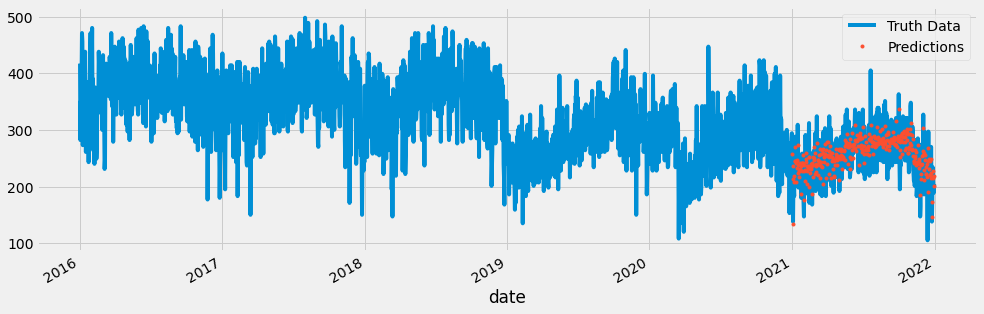

In [79]:
#plot the prediction from sample data
ax = df[['Frequency']].plot(figsize=(15, 5))
test_data['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])

In [80]:
#mean_absolute_percentage_error
actual_data = df.loc[df.index>= '01-01-2021']
mean_absolute_percentage_error(actual_data["Frequency"], test_data["prediction"])

0.08192137329736833

In [23]:
actual_data

,Frequency,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3
date,,,,,,,,,,
2021-01-01,258,2021,1,1,4,1,1,312.0,309.0,375.0
2021-01-02,249,2021,1,2,5,1,2,321.0,249.0,264.0
2021-01-03,138,2021,1,3,6,1,3,318.0,297.0,294.0
2021-01-04,204,2021,1,4,0,1,4,222.0,291.0,249.0
2021-01-05,198,2021,1,5,1,1,5,204.0,369.0,249.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,234,2021,12,27,0,4,361,273.0,228.0,282.0
2021-12-28,213,2021,12,28,1,4,362,225.0,300.0,243.0
2021-12-29,201,2021,12,29,2,4,363,273.0,249.0,303.0


In [24]:
#mean square error
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(actual_data["Frequency"],test_data["prediction"]))
print("RMSE: ", rms)

RMSE:  20.932818380001798


In [25]:
df.index.max()


Timestamp('2021-12-31 00:00:00')

In [26]:
#create future data
future = pd.date_range('2022-01-01','2022-12-31')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [27]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,Frequency,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture
2022-01-01,NaN,2022,1,1,5,1,1,264.0,258.0,237.0,True
2022-01-02,NaN,2022,1,2,6,1,2,327.0,276.0,195.0,True
2022-01-03,NaN,2022,1,3,0,1,3,213.0,243.0,243.0,True
2022-01-04,NaN,2022,1,4,1,1,4,186.0,306.0,237.0,True
2022-01-05,NaN,2022,1,5,2,1,5,297.0,297.0,306.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,2022,12,27,1,4,361,NaN,NaN,NaN,True
2022-12-28,NaN,2022,12,28,2,4,362,NaN,NaN,NaN,True
2022-12-29,NaN,2022,12,29,3,4,363,NaN,NaN,NaN,True
2022-12-30,NaN,2022,12,30,4,4,364,NaN,NaN,NaN,True


In [28]:
#predict future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


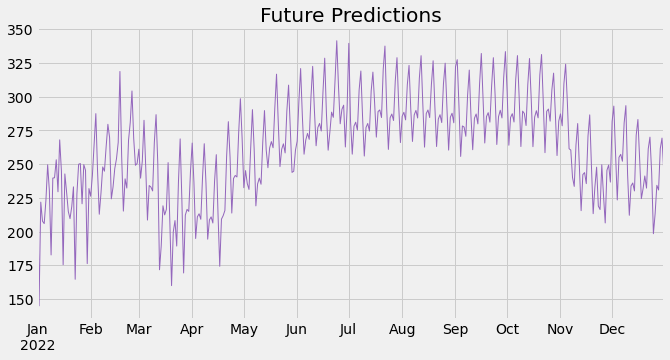

In [29]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [30]:
del future_w_features['Frequency']
future_w_features = future_w_features.rename(columns={'pred':'Frequency'})





In [31]:
future_w_features

,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture,Frequency
2022-01-01,2022,1,1,5,1,1,264.0,258.0,237.0,True,268.804962
2022-01-02,2022,1,2,6,1,2,327.0,276.0,195.0,True,144.915253
2022-01-03,2022,1,3,0,1,3,213.0,243.0,243.0,True,221.773819
2022-01-04,2022,1,4,1,1,4,186.0,306.0,237.0,True,207.665329
2022-01-05,2022,1,5,2,1,5,297.0,297.0,306.0,True,205.877975
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,2022,12,27,1,4,361,NaN,NaN,NaN,True,234.248581
2022-12-28,2022,12,28,2,4,362,NaN,NaN,NaN,True,230.796906
2022-12-29,2022,12,29,3,4,363,NaN,NaN,NaN,True,261.487244
2022-12-30,2022,12,30,4,4,364,NaN,NaN,NaN,True,269.254028


In [32]:
#merge future_w_features and df
final_data = pd.concat([df, future_w_features])
final_data = final_data['Frequency']
final_data


2016-01-02    417.000000
2016-01-03    282.000000
2016-01-04    351.000000
2016-01-05    345.000000
2016-01-06    396.000000
                 ...    
2022-12-27    234.248581
2022-12-28    230.796906
2022-12-29    261.487244
2022-12-30    269.254028
2022-12-31    245.088165
Name: Frequency, Length: 2547, dtype: float64

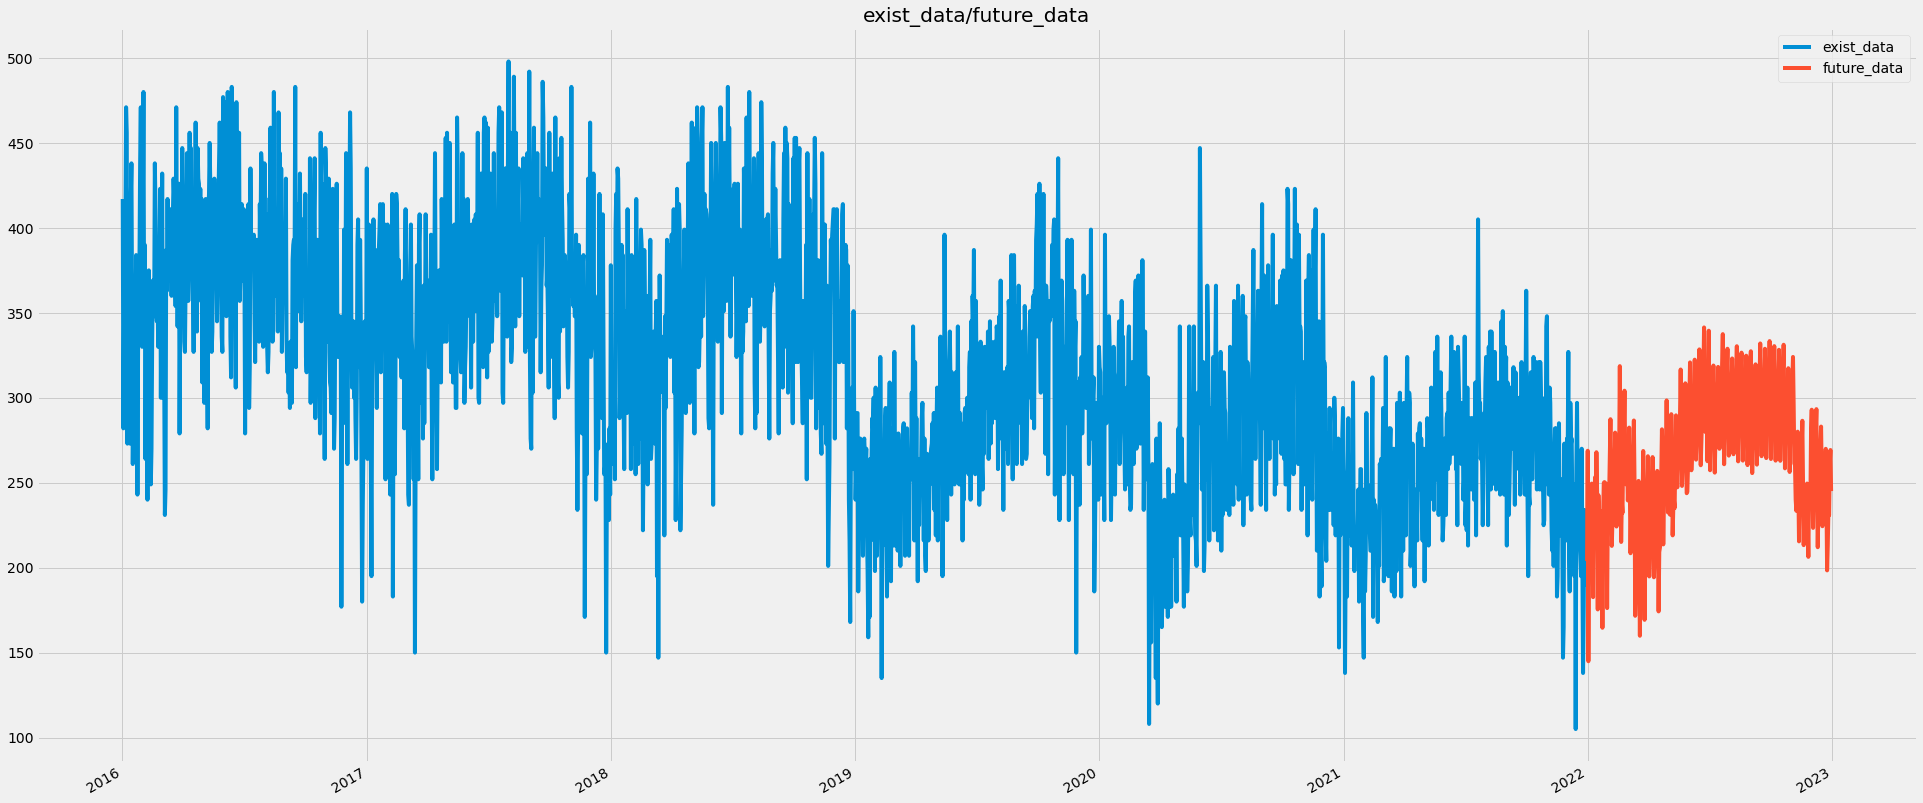

In [33]:
#plot the exist data with future data
exist_data = final_data.loc[final_data.index<'12-31-2021']
future_data = final_data.loc[final_data.index>='12-31-2021']

fig, ax = plt.subplots(figsize=(30,15))
exist_data.plot(ax=ax,label="exist_data",title='exist_data/future_data')
future_data.plot(ax=ax,label='future_data')
ax.legend(['exist_data','future_data'])
plt.show()

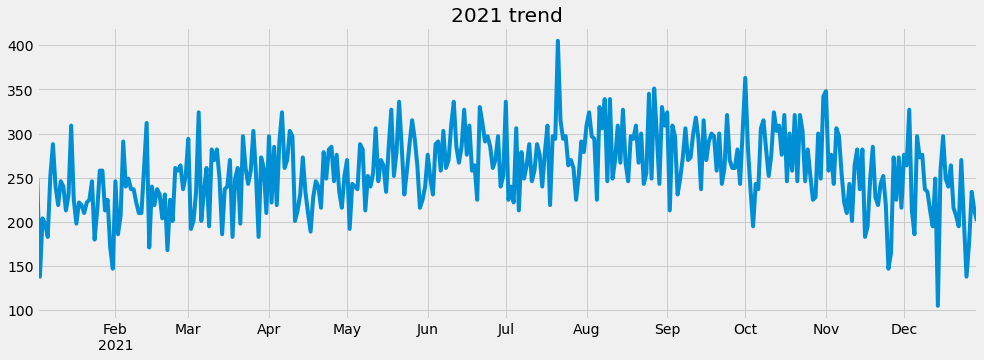

In [34]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2021') & (final_data.index<'12-30-2021')] \
.plot(figsize=(15,5),title="2021 trend")
plt.show()

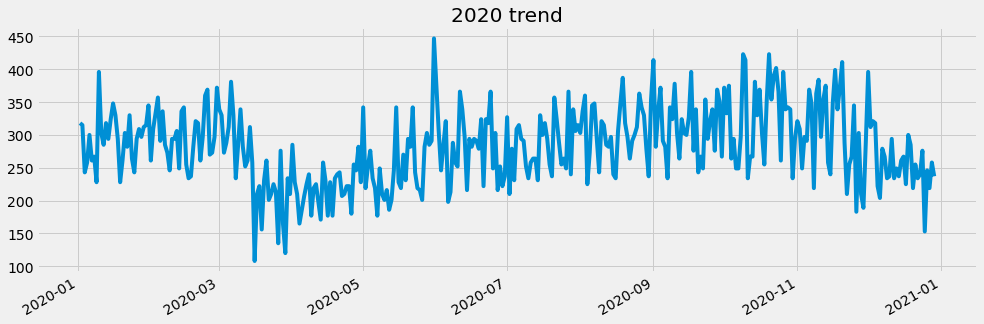

In [35]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2020') & (final_data.index<'12-30-2020')] \
.plot(figsize=(15,5),title="2020 trend")
plt.show()

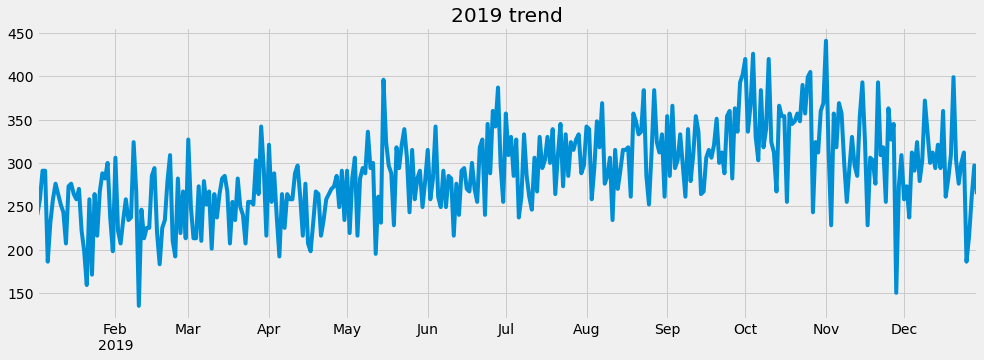

In [36]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2019') & (final_data.index<'12-30-2019')] \
.plot(figsize=(15,5),title="2019 trend")
plt.show()

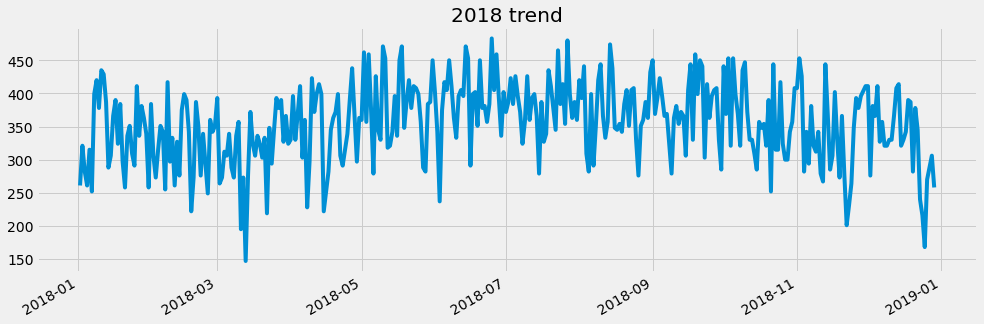

In [37]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2018') & (final_data.index<'12-30-2018')] \
.plot(figsize=(15,5),title="2018 trend")
plt.show()

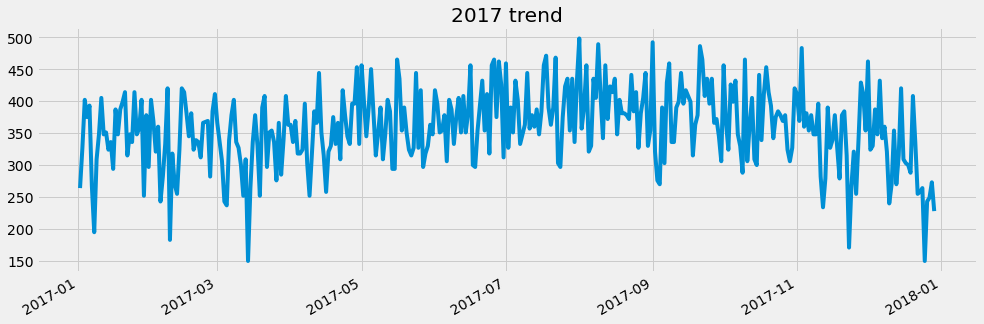

In [38]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2017') & (final_data.index<'12-30-2017')] \
.plot(figsize=(15,5),title="2017 trend")
plt.show()

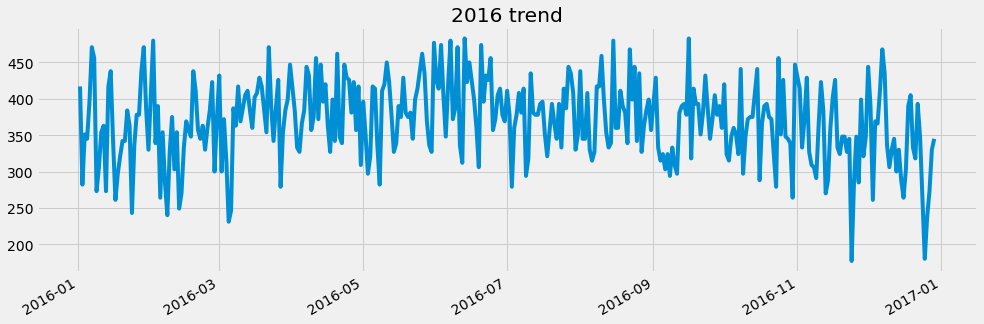

In [39]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2016') & (final_data.index<'12-30-2016')] \
.plot(figsize=(15,5),title="2016 trend")
plt.show()

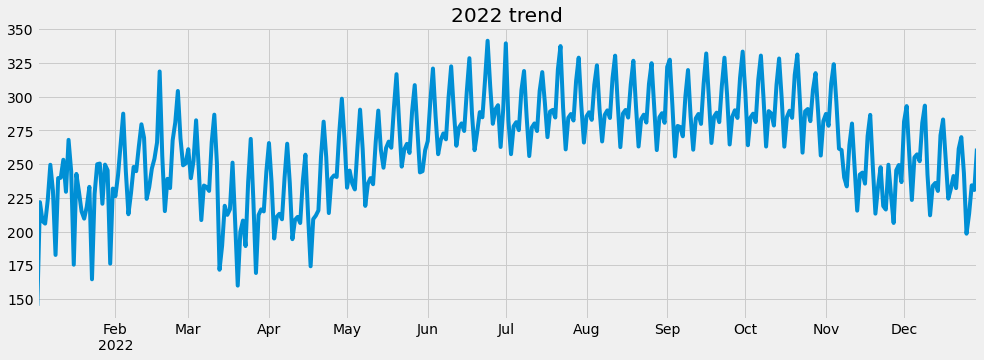

In [40]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2022') & (final_data.index<'12-30-2022')] \
.plot(figsize=(15,5),title="2022 trend")
plt.show()